In [1]:
%load "../rapaio-bootstrap"

In [2]:
Random random = new Random(42)

In [3]:
double cosine(DVector u, DVector v) {return u.dot(v) / (u.norm(2) * v.norm(2));}

In [51]:
Var takeCosineSample(DMatrix inputs, int size) {
    VarDouble sample = VarDouble.empty();
    for (int i = 0; i < size; i++) {
        int ii = random.nextInt(inputs.rowCount());
        int jj = random.nextInt(inputs.rowCount());
        sample.addDouble(cosine(inputs.mapRow(ii), inputs.mapRow(jj)));
    }
    return sample;
}

In [52]:
DMatrix pool2dMean(DMatrix inputs, int size, int step) {
    DMatrix pool = DMatrix.empty((inputs.rowCount() - size) / step, (inputs.colCount() - size) / step);
    for (int i = 0; i < pool.rowCount(); i++) {
        for (int j = 0; j < pool.colCount(); j++) {

            VarDouble mean = VarDouble.empty();
            for (int ii = 0; ii < step; ii++) {
                for (int jj = 0; jj < step; jj++) {
                    if(ii==jj) {
                        continue;
                    }
                    mean.addDouble(inputs.get(i * step + ii, j * step + jj));
                }
            }
            pool.set(i, j, mean.op().nanmean());
        }
    }
    return pool;
}

In [53]:
DMatrix pool2dMax(DMatrix inputs, int size, int step) {
    DMatrix pool = DMatrix.empty((inputs.rowCount() - size) / step, (inputs.colCount() - size) / step);
    for (int i = 0; i < pool.rowCount(); i++) {
        for (int j = 0; j < pool.colCount(); j++) {

            double max = inputs.get(i * step, j * step);
            for (int ii = 0; ii < step; ii++) {
                for (int jj = 0; jj < step; jj++) {
                    if(ii==jj) {
                        continue;
                    }
                    max = Math.max(max, inputs.get(i * step + ii, j * step + jj));
                }
            }
            pool.set(i, j, max);
        }
    }
    return pool;
}

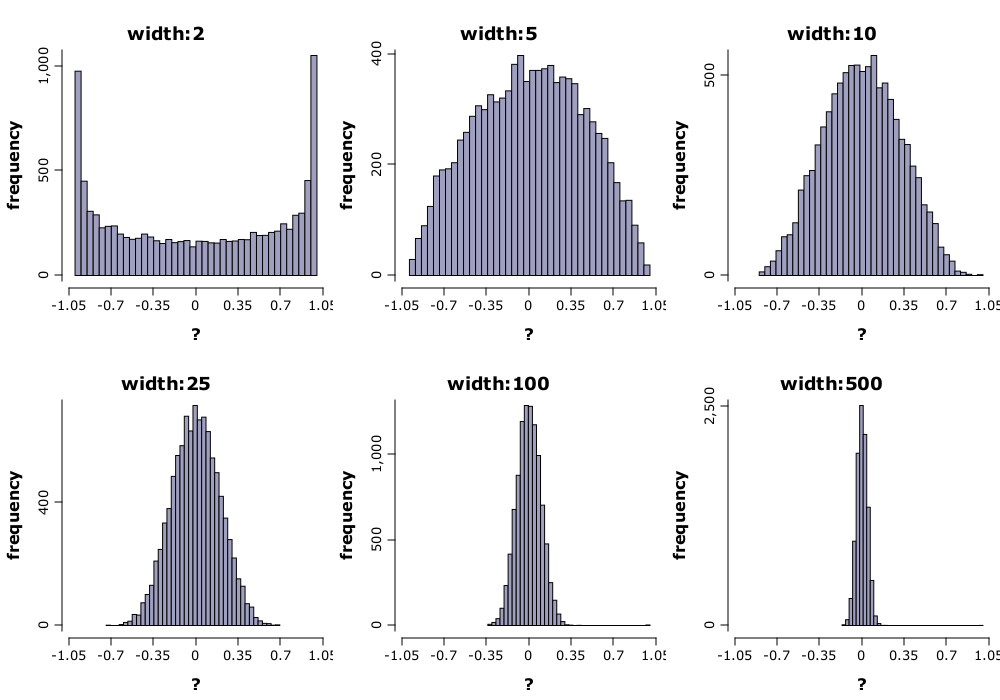

In [54]:
int n = 10_000;
int m = 768;
IntInt2DoubleBiFunction generator = (i, j) -> random.nextGaussian();
DMatrix inputs = DMatrix.fill(n, m, generator);

VarInt widths = VarInt.wrap(2, 5, 10, 25, 100, 500);
GridLayer gl = gridLayer(2, widths.size()/2);

for (int i = 0; i < widths.size(); i++) {
    var filtered = inputs.rangeCols(0, widths.getInt(i));
    gl.add(hist(takeCosineSample(filtered, 10_000), -1, 1, bins(40)).xLim(-1, 1).title("width:" + widths.getInt(i)));
}
WS.image(gl, 1000, 700);

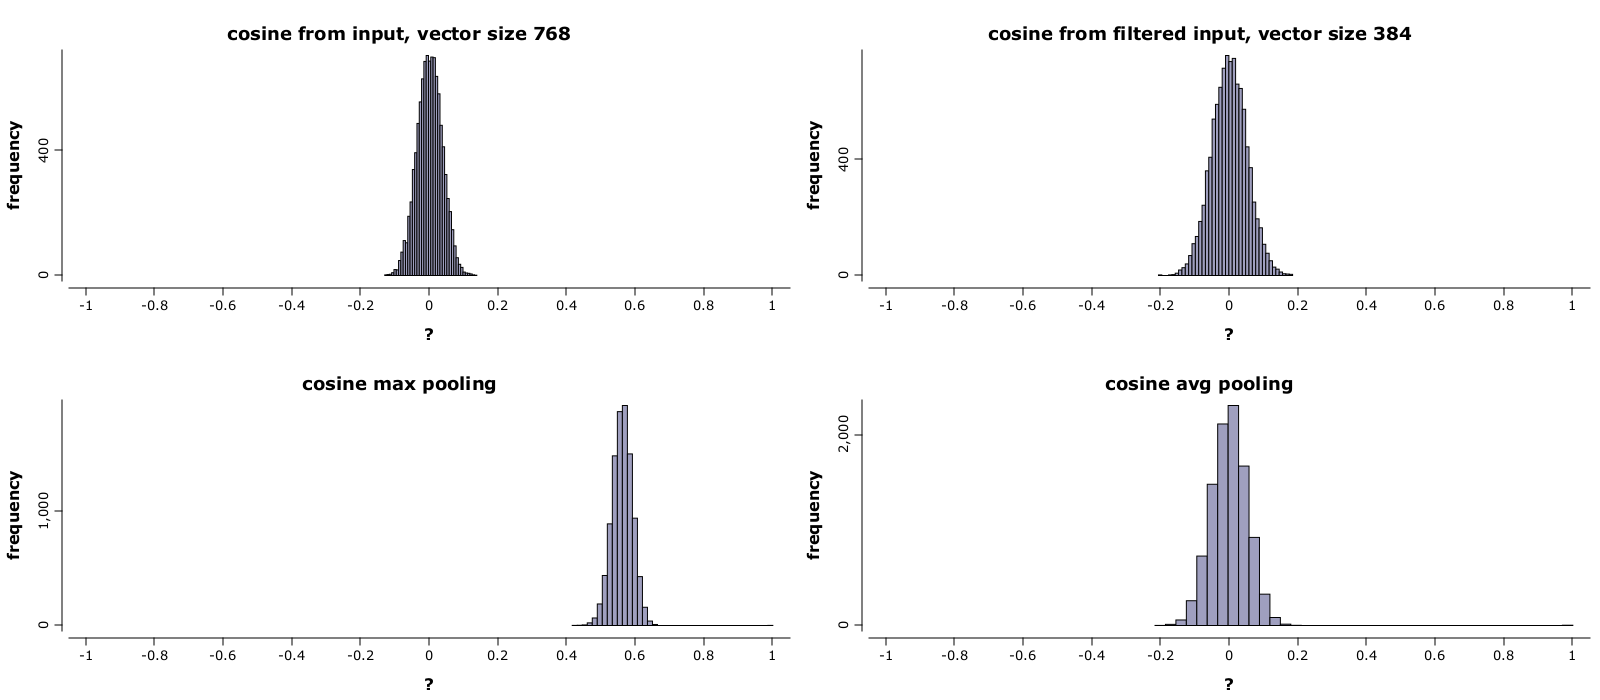

In [62]:
int poolSize = 2;
int poolSlide = 2;

var initialSample = takeCosineSample(inputs, 10_000);
var filteredSample = takeCosineSample(inputs.rangeCols(0, inputs.colCount()/poolSlide), 10_000);
var maxSample = takeCosineSample(pool2dMax(inputs, poolSize,  poolSlide), 10_000);
var meanSample = takeCosineSample(pool2dMean(inputs, poolSize, poolSlide), 10_000);

double bw = 1;
WS.image(gridLayer(2, 2) 
        .add(hist(initialSample, -1, 1, bins(40)).xLim(-bw, bw).title("cosine from input, vector size " + inputs.colCount()))
        .add(hist(filteredSample, -1, 1, bins(40)).xLim(-bw, bw).title("cosine from filtered input, vector size " + inputs.colCount()/poolSlide))
        .add(hist(maxSample, -1, 1, bins(40)).xLim(-bw, bw).title("cosine max pooling"))
        .add(hist(meanSample, -1, 1, bins(40)).xLim(-bw, bw).title("cosine avg pooling"))
, 1600, 700);